In [1]:
"""Sanity check on booth function. All optimizers should converge."""
import pytest
import torch
import torchzero as tz

def booth(x,y):
    return (x + 2 * y - 7) ** 2 + (2 * x + y - 5) ** 2

x0 = (0, -8)

def _test_optimizer(lmbda, tol=1e-1):
    params = torch.tensor(x0, dtype=torch.float32, requires_grad=True)
    opt = lmbda([params])
    
    def closure(backward=True):
        loss = booth(*params)
        if backward:
            opt.zero_grad()
            loss.backward()
        return loss
    
    losses = []
    for i in range(100):
        loss = opt.step(closure)
        losses.append(loss)
        assert isinstance(loss, torch.Tensor), (i, type(loss), loss)
        assert torch.isfinite(loss), (i, loss)
        
    assert loss <= tol, (tol, loss, [i.detach().cpu().item() for i in losses])
    print(opt.__class__.__name__, loss.detach().cpu().item())

In [10]:
opt = lambda p: tz.optim.ReciprocalSGD(p, 1e-1)
_test_optimizer(opt)        

AssertionError: (0.1, tensor(87.6583, grad_fn=<AddBackward0>), [698.0, 683.01123046875, 668.2044677734375, 653.5797729492188, 639.1373291015625, 624.876953125, 610.7989501953125, 596.903076171875, 583.189697265625, 569.6587524414062, 556.310302734375, 543.1444091796875, 530.1611938476562, 517.3607177734375, 504.7430419921875, 492.3082275390625, 480.05645751953125, 467.9877624511719, 456.1021728515625, 444.39996337890625, 432.8810729980469, 421.5456848144531, 410.39385986328125, 399.42578125, 388.6416931152344, 378.04144287109375, 367.6253356933594, 357.3934326171875, 347.34600830078125, 337.4831848144531, 327.8051452636719, 318.3120422363281, 309.0039367675781, 299.8812255859375, 290.94403076171875, 282.192626953125, 273.6271667480469, 265.2479248046875, 257.0552062988281, 249.0492401123047, 241.23031616210938, 233.59877014160156, 226.15489196777344, 218.8990936279297, 211.83169555664062, 204.9530792236328, 198.2637176513672, 191.76405334472656, 185.45448303222656, 179.33563232421875, 173.4080047607422, 167.67214965820312, 162.12872314453125, 156.77835083007812, 151.6217803955078, 146.65972900390625, 141.89305114746094, 137.32261657714844, 132.94927978515625, 128.77407836914062, 124.79805755615234, 121.02230072021484, 117.44801330566406, 114.076416015625, 110.9088134765625, 107.94660186767578, 105.19112396240234, 102.64384460449219, 100.30622863769531, 98.17958068847656, 96.26530456542969, 94.5645523071289, 93.07828521728516, 91.80722045898438, 90.75150299072266, 89.91079711914062, 89.28401184082031, 88.8690414428711, 88.66276550292969, 88.66069030761719, 88.55757141113281, 88.56210327148438, 88.45240783691406, 88.46354675292969, 88.34722900390625, 88.364990234375, 88.24208068847656, 88.26647186279297, 88.13690185546875, 88.1679916381836, 88.03174591064453, 88.06952667236328, 87.92658996582031, 87.97109985351562, 87.82144927978516, 87.86812591552734, 87.72279357910156, 87.76322937011719, 87.62410736083984, 87.65829467773438])

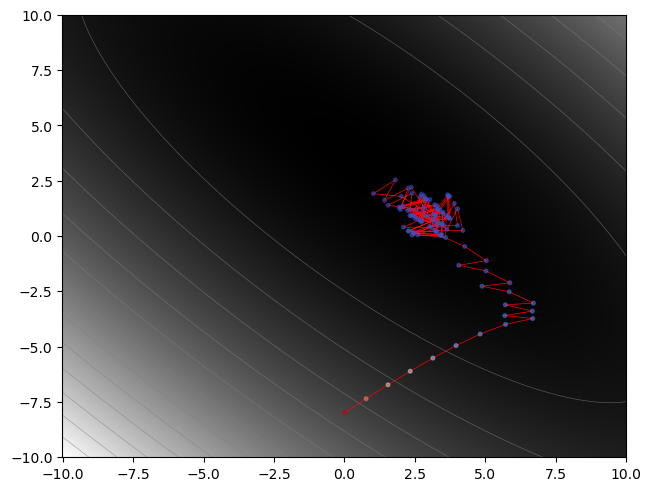

In [15]:
from visualbench.tasks.function_descent import FunctionDescent

f = FunctionDescent('booth')
opt = lambda p: tz.optim.ReciprocalSGD(p, 1)
f.run(opt(f.parameters()), 100)
f.plot_solution()